In [35]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
#import pandas as pd
# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.figure(figsize=(15,5))

# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a data feed and set formet
#data_sentiment=bt.feeds.GenericCSVData(dataname="/Users/tyllersun/Desktop/大一/data_science/bond.csv")
#/Users/tyllersun/Desktop/data0.csv
#data_1 = bt.feeds.GenericCSVData(dataname='/Users/tyllersun/Desktop/data0_test.csv',
data_1 = bt.feeds.GenericCSVData(dataname='data0_new.csv',
fromdate=datetime.datetime(2015, 5, 1), # startdate
todate=datetime.datetime(2019, 1, 1), # enddate
                                     
dtformat=('%Y-%m-%d'),tmformat=('%H.%M.%S'),
    date=0, open=1, close=2, high=3, low=4,
    volume=7, openinterest=8, positive_std=-1, negative_std=-1 ,code=-1,
    reverse=False)
#print("finish")
#print(data_1.positive_std)

In [7]:
# Create a Stratey #Buy if price continuelly fall for 3d & Sell every 5d
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
                
        # To keep track of pending orders #掛單
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):  # 每過5天 -> sell!
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
               

In [36]:
class sentiment_strategy(bt.Strategy):
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        #print("s")
        #high
        #print(self.datas[0].volume)
        self.data_positive = self.datas[0].volume
        self.data_negative = self.datas[0].openinterest
        self.dataclose = self.datas[0].close
        #print("finish_init")
           
    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('sentiment, %.2f' % self.dataclose[0])
        #print("a")
        time=10
        total_pos=0
        total_neg=0
        for i in range(time):
            where=i-14
            total_pos=total_pos+self.data_positive[where]
            total_neg=total_neg+self.data_negative[where]
        total_pos_avg=total_pos/time
        total_neg_avg=total_neg/time
        #print("b")
        if  total_pos_avg > self.data_positive[0]*(2.3):
            #print("w")
            print(total_pos_avg)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.buy(size=5)
        else: 
            if total_neg_avg > self.data_negative[0]*(2.3):
                #print("c")
                print(total_neg_avg)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.sell(size=5)
       
    """"   
        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()
        """

In [8]:
class RSI_Strategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [30]:
class MA_CrossOver(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    Note:
      - Although the default
    Buy Logic:
      - No position is open on the data
      - The ``fast`` moving averagecrosses over the ``slow`` strategy to the
        upside.
    Sell Logic:
      - A position exists on the data
      - The ``fast`` moving average crosses over the ``slow`` strategy to the
        downside
    Order Execution Type:
      - Market
    '''
    alias = ('SMA_CrossOver',)

    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 30),
        # moving average to use
        ('_movav', btind.MovAv.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast)
        sma_slow = self.p._movav(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if self.buysig < 0:
                self.sell()

        elif self.buysig > 0:
            self.buy()

In [37]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8  # that's default image size for this interactive session

pylab.rcParams['font.family'] = 'Segoe Script'
pylab.rcParams['font.sans-serif'] = ['Segoe Script']

#pylab.rcParams['font.family'] = 'sans-serif'
#pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "10"

Starting Portfolio Value: 100000.00
-0.32755296085105845
2015-05-01, BUY CREATE, 163.89
2015-05-04, BUY EXECUTED, Price: 164.19, Cost: 820.96, Comm 0.82
0.4415548049463351
2015-05-04, SELL CREATE, 164.84
2015-05-05, SELL EXECUTED, Price: 164.09, Cost: 820.96, Comm 0.82
2015-05-05, OPERATION PROFIT, GROSS -0.50, NET -2.14
0.4335854052452987
2015-05-05, SELL CREATE, 164.42
2015-05-06, SELL EXECUTED, Price: 163.76, Cost: -818.82, Comm 0.82
-0.25007101567686385
2015-05-06, BUY CREATE, 164.11
2015-05-07, BUY EXECUTED, Price: 162.17, Cost: -818.82, Comm 0.81
2015-05-07, OPERATION PROFIT, GROSS 7.97, NET 6.34
0.47014865399192524
2015-05-07, SELL CREATE, 163.61
2015-05-08, SELL EXECUTED, Price: 164.92, Cost: -824.60, Comm 0.82
0.45453015660232765
2015-05-08, SELL CREATE, 165.72
2015-05-11, SELL EXECUTED, Price: 165.49, Cost: -827.46, Comm 0.83
-0.09510460338833457
2015-05-11, BUY CREATE, 165.70
2015-05-12, BUY EXECUTED, Price: 163.97, Cost: -826.03, Comm 0.82
0.2617682014058116
2015-05-12, SEL

2015-11-04, BUY EXECUTED, Price: 165.38, Cost: 826.89, Comm 0.83
0.12778564528302766
2015-11-04, BUY CREATE, 165.40
2015-11-05, BUY EXECUTED, Price: 164.62, Cost: 823.12, Comm 0.82
0.18689525677361482
2015-11-05, BUY CREATE, 165.08
2015-11-06, BUY EXECUTED, Price: 164.38, Cost: 821.92, Comm 0.82
0.1745069318479628
2015-11-06, BUY CREATE, 165.01
2015-11-09, BUY EXECUTED, Price: 164.39, Cost: 821.97, Comm 0.82
0.11606794637308074
2015-11-09, SELL CREATE, 164.49
2015-11-10, SELL EXECUTED, Price: 162.99, Cost: 786.28, Comm 0.81
0.19255301715057788
2015-11-10, BUY CREATE, 163.80
2015-11-11, BUY EXECUTED, Price: 164.09, Cost: 820.45, Comm 0.82
0.18195820556808726
2015-11-11, BUY CREATE, 164.15
2015-11-12, BUY EXECUTED, Price: 162.17, Cost: 810.87, Comm 0.81
0.1671728588161956
2015-11-12, BUY CREATE, 162.41
2015-11-13, BUY EXECUTED, Price: 160.31, Cost: 801.57, Comm 0.80
-0.11020627171191152
2015-11-16, BUY CREATE, 161.22
2015-11-17, BUY EXECUTED, Price: 161.72, Cost: 808.61, Comm 0.81
-0.520

2016-09-08, BUY CREATE, 174.36
2016-09-09, BUY EXECUTED, Price: 172.91, Cost: 864.53, Comm 0.86
-0.3664538816742059
2016-09-13, BUY CREATE, 171.73
2016-09-14, BUY EXECUTED, Price: 170.33, Cost: 851.67, Comm 0.85
-0.3377066549967154
2016-09-14, BUY CREATE, 171.18
2016-09-15, BUY EXECUTED, Price: 169.89, Cost: 849.45, Comm 0.85
-0.19523570741988033
2016-09-15, BUY CREATE, 172.01
2016-09-16, BUY EXECUTED, Price: 171.29, Cost: 856.44, Comm 0.86
-0.014830815142805986
2016-09-16, BUY CREATE, 171.29
2016-09-19, BUY EXECUTED, Price: 171.65, Cost: 858.23, Comm 0.86
0.09753371723852522
2016-09-19, BUY CREATE, 172.06
2016-09-20, BUY EXECUTED, Price: 171.58, Cost: 857.90, Comm 0.86
-0.017693322486433495
2016-09-20, BUY CREATE, 171.80
2016-09-21, BUY EXECUTED, Price: 171.44, Cost: 857.20, Comm 0.86
-0.0395664001643933
2016-09-21, BUY CREATE, 172.55
2016-09-22, BUY EXECUTED, Price: 173.33, Cost: 866.63, Comm 0.87
-0.1751959806952201
2016-09-22, SELL CREATE, 173.89
2016-09-23, SELL EXECUTED, Price: 1

-0.6780301108667187
2017-06-13, SELL CREATE, 204.52
2017-06-14, SELL EXECUTED, Price: 204.90, Cost: 889.29, Comm 1.02
-0.5087361991850351
2017-06-14, BUY CREATE, 205.11
2017-06-15, BUY EXECUTED, Price: 204.04, Cost: 1020.22, Comm 1.02
-0.5261924560731736
2017-06-15, BUY CREATE, 204.92
2017-06-16, Order Canceled/Margin/Rejected
-0.6025104218624263
2017-06-20, SELL CREATE, 206.51
2017-06-21, SELL EXECUTED, Price: 206.11, Cost: 890.41, Comm 1.03
-0.30862917234707765
2017-06-21, BUY CREATE, 206.13
2017-06-22, BUY EXECUTED, Price: 205.56, Cost: 1027.82, Comm 1.03
-0.38337062039565345
2017-06-22, BUY CREATE, 205.77
2017-06-23, Order Canceled/Margin/Rejected
-0.23870793642558114
2017-06-23, BUY CREATE, 205.44
2017-06-26, Order Canceled/Margin/Rejected
-0.015261504993053298
2017-06-26, SELL CREATE, 206.22
2017-06-27, SELL EXECUTED, Price: 205.21, Cost: 891.59, Comm 1.03
-0.2041363122024534
2017-06-27, BUY CREATE, 205.61
2017-06-28, BUY EXECUTED, Price: 205.08, Cost: 1025.42, Comm 1.03
-0.20334

2018-03-21, BUY EXECUTED, Price: 241.13, Cost: 1205.67, Comm 1.21
0.1541931435188544
2018-03-21, BUY CREATE, 243.58
2018-03-22, BUY EXECUTED, Price: 238.16, Cost: 1190.79, Comm 1.19
0.07692551322467078
2018-03-22, BUY CREATE, 239.07
2018-03-23, Order Canceled/Margin/Rejected
-0.04406598603489474
2018-03-23, BUY CREATE, 235.04
2018-03-26, Order Canceled/Margin/Rejected
-0.04896484279161794
2018-03-26, BUY CREATE, 236.26
2018-03-27, Order Canceled/Margin/Rejected
-0.058562750592618895
2018-03-28, BUY CREATE, 234.87
2018-03-29, Order Canceled/Margin/Rejected
-0.05695001861187756
2018-04-03, SELL CREATE, 234.41
2018-04-04, SELL EXECUTED, Price: 229.34, Cost: 965.34, Comm 1.15
-0.04326354296899097
2018-04-05, SELL CREATE, 240.11
2018-04-06, SELL EXECUTED, Price: 236.41, Cost: 965.34, Comm 1.18
-0.07094296463392458
2018-04-10, BUY CREATE, 239.05
2018-04-11, BUY EXECUTED, Price: 236.24, Cost: 1181.22, Comm 1.18
-0.03943098424654411
2018-04-11, BUY CREATE, 237.66
2018-04-12, BUY EXECUTED, Pric

<IPython.core.display.Javascript object>


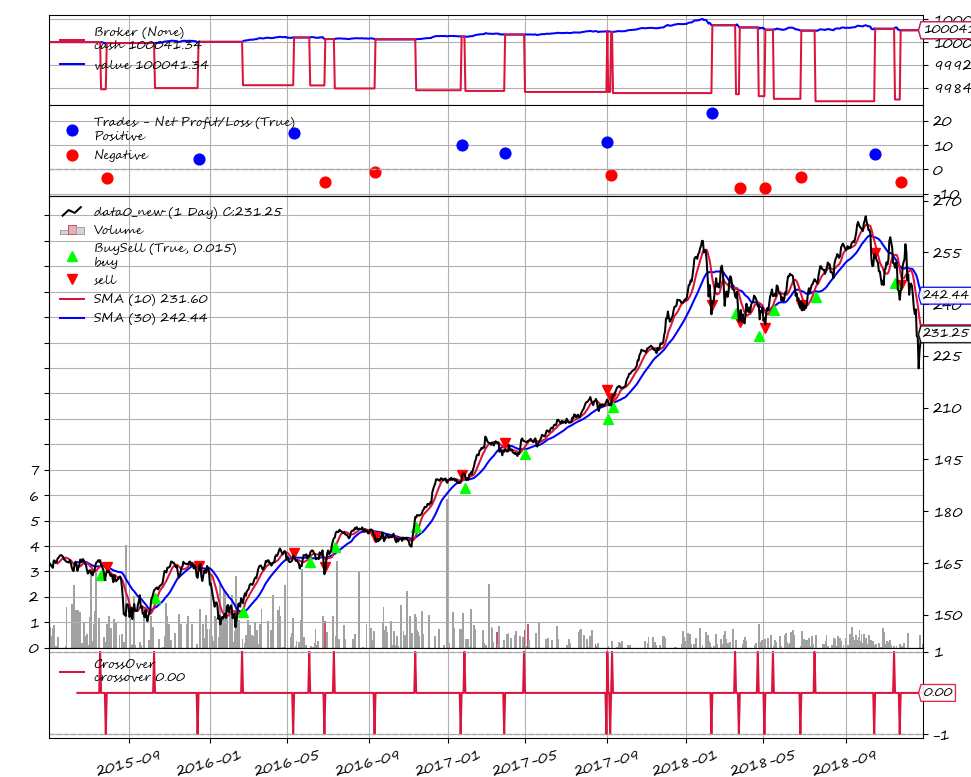

In [38]:
import pandas as pd
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(sentiment_strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 102119.15


<IPython.core.display.Javascript object>


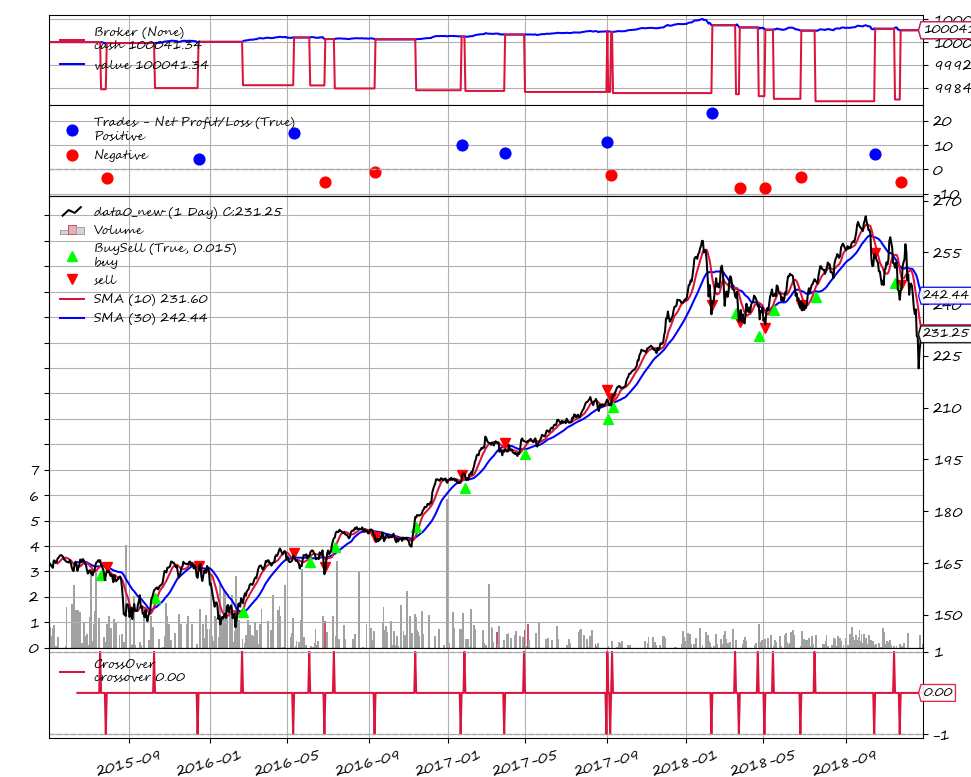

In [15]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(RSI_Strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

In [39]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(MA_CrossOver)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result


Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.34
